In [1]:
#!/usr/bin/env python
# coding: utf-8
import meep as mp
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def generate_waveguide(N, intra_pair_spacing, inter_pair_spacing, radius):
        # Adjust spacings to include the diameters of the circles
        adjusted_intra_pair_spacing = intra_pair_spacing + 2 * radius
        adjusted_inter_pair_spacing = inter_pair_spacing + 2 * radius
        
        # Generate the list with adjusted spacings
        result = [0]
        for i in range(1, N):
            if i % 2 == 1:  # If it's an odd index, use adjusted intra-pair spacing
                next_value = result[-1] + adjusted_intra_pair_spacing
            else:  # For even indices, use adjusted inter-pair spacing
                next_value = result[-1] + adjusted_inter_pair_spacing
            result.append(next_value)
        
        # Find the center value
        if N % 2 == 1:
            center_value = result[len(result) // 2]
        else:
            center_value = (result[(len(result) // 2) - 1] + result[len(result) // 2]) / 2
        
        # Shift the list so the center value is at 0
        shifted_result = [x - center_value for x in result]
        
        return shifted_result

In [3]:
# Material definitions
n_SiO2 = 1.45  # Refractive index of SiO2
eps_SiO2 = n_SiO2**2  # Dielectric constant of SiO2

resolution = 20  # pixels/um
w = 2  # width of waveguide in um
r = 0.5  # radius of holes in um
t_1 = 1  # intra-pair spacing
t_2 = 2  # inter-pair spacing (defect spacing, ordinary spacing = 1)
sy = 10  # size of cell in y direction (perpendicular to waveguide), in um
pad = 7  # padding between last hole and PML edge, in um
dpml = 1  # PML thickness, in um
N = 16  # number of holes

In [4]:
wl = 0.4    # source wavelength (in μm)
fcen = 1/wl  # pulse center frequency (in 1/μm)
df = 0.001  # pulse width (in frequency, in 1/μm)
nfreq = 500  # number of frequency points to compute flux

     block, center = (0,0,0)
          size (1e+20,2,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)


          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)


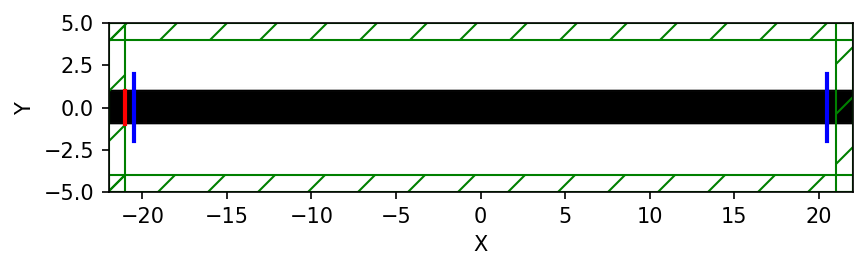

-----------
Initializing structure...
time for choose_chunkdivision = 0.000362158 s
Working in 2D dimensions.
Computational cell is 44 x 10 x 0 with resolution 20
     block, center = (0,0,0)
          size (1e+20,2,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
time for set_epsilon = 0.310932 s
-----------
field decay(t = 50.025000000000006): 1.0237198109292607e-18 / 1.0237198109292607e-18 = 1.0
on time step 3028 (time=75.7), 0.00132118 s/step
field decay(t = 100.05000000000001): 2.481165271373844e-12 / 2.481165271373844e-12 = 1.0
field decay(t = 150.07500000000002): 2.442068720022027e-12 / 2.481165271373844e-12 = 0.9842426654109306
on time step 6066 (time=151.65), 0.00131671 s/step
field decay(t = 200.10000000000002): 4.004128383172241e-12 / 4.004128383172241e-12 = 1.0
on time step 8975 (time=224.375), 0.00137522 s/step
field decay(t = 250.125): 6.275568163921326e-12 / 6.275568163921326e-12 = 1.0
field decay(t =

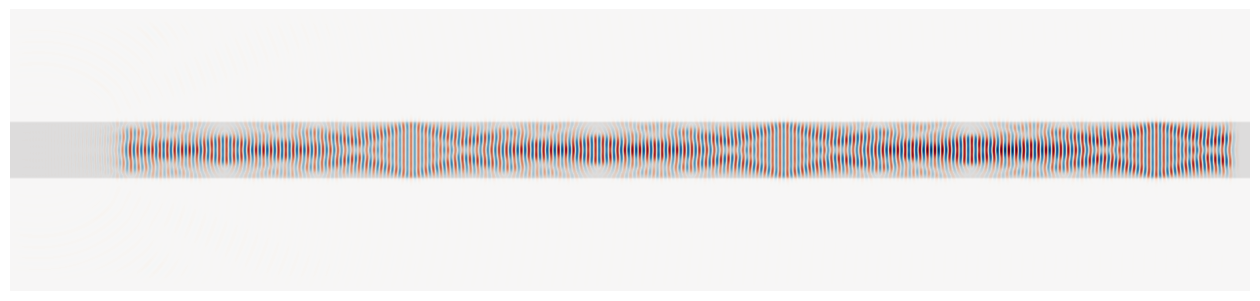

In [5]:
# Calculate the size of the cell in the x direction
if N % 2 == 0:
    sx = 2 * (pad + dpml + N // 2 + 2 * N // 2) - 20
else:
    sx = 2 * (pad + dpml + (N + 1) // 2 + 2 * (N + 1) // 2) - 20


cell = mp.Vector3(sx, sy, 0)
pml_layers = [mp.PML(dpml)]

# Define the waveguide material
SiO2_material = mp.Medium(epsilon=eps_SiO2)


# Source
sources = [mp.Source(mp.GaussianSource(wavelength=wl, fwidth=df),
                     component=mp.Ez,
                     center=mp.Vector3(-0.5 * sx + dpml),
                     size=mp.Vector3(0, w, 0))]

# Normalization run simulation
norm_sim = mp.Simulation(cell_size=cell,
                         boundary_layers=pml_layers,
                         geometry=[mp.Block(size=mp.Vector3(mp.inf, w, mp.inf), material=SiO2_material)],  # No holes for normalization
                         sources=sources,
                         resolution=resolution)



# Flux monitors
refl_fr = mp.FluxRegion(center=mp.Vector3(-0.5 * sx + dpml + 0.5), size=mp.Vector3(0, 2*w, 0))
tran_fr = mp.FluxRegion(center=mp.Vector3(0.5 * sx - dpml - 0.5), size=mp.Vector3(0, 2*w, 0))


# Add flux monitors
norm_refl = norm_sim.add_flux(fcen, df, nfreq, refl_fr)
norm_tran = norm_sim.add_flux(fcen, df, nfreq, tran_fr)

plt.figure(dpi=150)
norm_sim.plot2D()
plt.show()

# Run normalization simulation
norm_sim.run(until_after_sources=mp.stop_when_fields_decayed(50, mp.Ez, mp.Vector3(0.5 * sx - dpml - 0.5), 1e-3))

eps_data = norm_sim.get_array(center=mp.Vector3(), size=cell, component=mp.Dielectric)
ez_data = norm_sim.get_array(center=mp.Vector3(), size=cell, component=mp.Ez)
plt.figure(figsize=(16,9) )
plt.imshow(eps_data.transpose(), interpolation='spline36', cmap='binary')
plt.imshow(ez_data.transpose(), interpolation='spline36', cmap='RdBu', alpha=0.9)
plt.axis('off')
plt.show()

# Save flux for normalization
norm_refl_data = norm_sim.get_flux_data(norm_refl)
norm_tran_data = norm_sim.get_flux_data(norm_tran)

# Calculate the incident power for normalization
norm_refl_flux = mp.get_fluxes(norm_refl)
norm_tran_flux = mp.get_fluxes(norm_tran)
norm_incident_flux = np.array(norm_refl_flux) + np.array(norm_tran_flux)

# Reset simulation for main run with holes
norm_sim.reset_meep()

     block, center = (0,0,0)
          size (1e+20,2,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
     cylinder, center = (-18.5,0,0)
          radius 0.5, height 1e+20, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (1,1,1)
     cylinder, center = (-16.5,0,0)
          radius 0.5, height 1e+20, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (1,1,1)
     cylinder, center = (-13.5,0,0)
          radius 0.5, height 1e+20, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (1,1,1)
     cylinder, center = (-11.5,0,0)
          radius 0.5, height 1e+20, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (1,1,1)
     cylinder, center = (-8.5,0,0)
          radius 0.5, height 1e+20, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (1,1,1)
     cylinder, center = (-6.5,0,0)
          radius 0.5, height 1e+20, axis (0, 0, 1)
          dielectric c

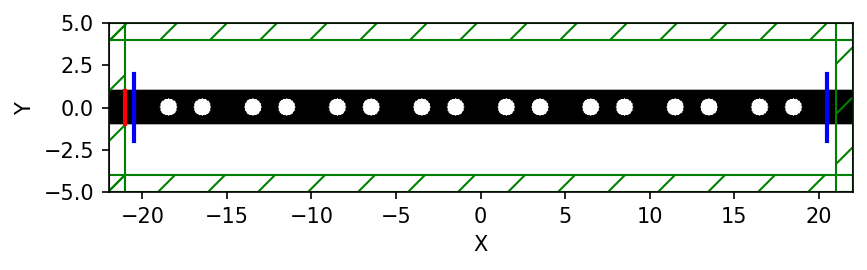

-----------
Initializing structure...
time for choose_chunkdivision = 0.000837088 s
Working in 2D dimensions.
Computational cell is 44 x 10 x 0 with resolution 20
     block, center = (0,0,0)
          size (1e+20,2,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
     cylinder, center = (-18.5,0,0)
          radius 0.5, height 1e+20, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (1,1,1)
     cylinder, center = (-16.5,0,0)
          radius 0.5, height 1e+20, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (1,1,1)
     cylinder, center = (-13.5,0,0)
          radius 0.5, height 1e+20, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (1,1,1)
     cylinder, center = (-11.5,0,0)
          radius 0.5, height 1e+20, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (1,1,1)
     cylinder, center = (-8.5,0,0)
          radius 0.5, height 1e+20, axis (0, 0, 1)
  

KeyboardInterrupt: 

In [6]:
# Main simulation with holes
geometry_holes = [mp.Block(size=mp.Vector3(mp.inf, w, mp.inf), material=SiO2_material)]

hole_positions = generate_waveguide(N, t_1, t_2, r)
for x_position in hole_positions:
    geometry_holes.append(mp.Cylinder(r, height=mp.inf, center=mp.Vector3(x_position, 0, 0), material=mp.air))

sim = mp.Simulation(cell_size=cell,
                    boundary_layers=pml_layers,
                    geometry=geometry_holes,  # Geometry with holes
                    sources=sources,
                    resolution=resolution)



# Add flux monitors
refl = sim.add_flux(fcen, df, nfreq, refl_fr)
tran = sim.add_flux(fcen, df, nfreq, tran_fr)

plt.figure(dpi=150)
sim.plot2D()
plt.show()

# Load the saved flux data for normalization
sim.load_minus_flux_data(refl, norm_refl_data)

# Run simulation with holes
sim.run(until_after_sources=mp.stop_when_fields_decayed(50, mp.Ez, mp.Vector3(0.5 * sx - dpml - 0.5), 1e-3))

eps_data = sim.get_array(center=mp.Vector3(), size=cell, component=mp.Dielectric)
ez_data = sim.get_array(center=mp.Vector3(), size=cell, component=mp.Ez)
plt.figure(figsize=(16,9) )
plt.imshow(eps_data.transpose(), interpolation='spline36', cmap='binary')
plt.imshow(ez_data.transpose(), interpolation='spline36', cmap='RdBu', alpha=0.9)
plt.axis('off')
plt.show()

# Get the reflected and transmitted flux
reflected_flux = mp.get_fluxes(refl)
transmitted_flux = mp.get_fluxes(tran)

# Normalize the transmission and reflection
transmission = np.array(transmitted_flux) / norm_incident_flux
reflection = np.array(reflected_flux) / norm_incident_flux
freqs = np.linspace(fcen - df/2, fcen + df/2, nfreq)

# Plot the transmission and reflection
plt.figure(figsize=(10, 6))
plt.plot(freqs, transmission, label="Transmission")
plt.plot(freqs, reflection, label="Reflection")
plt.xlabel("Frequency (1/μm)")
plt.ylabel("Normalized Flux")
plt.legend()
plt.title("Transmission and Reflection Spectra")
plt.grid(True)
plt.show()


     block, center = (0,0,0)
          size (1e+20,2,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)


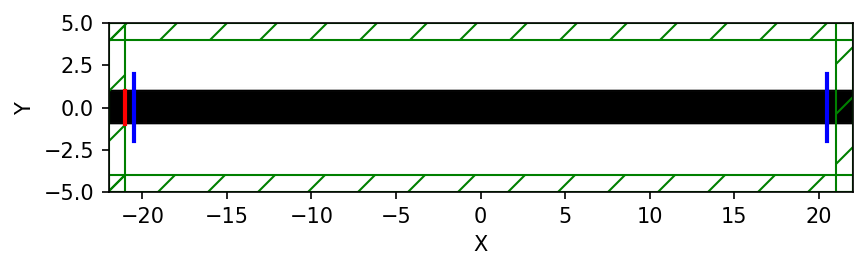

-----------
Initializing structure...
time for choose_chunkdivision = 0.000440121 s
Working in 2D dimensions.
Computational cell is 44 x 10 x 0 with resolution 20
     block, center = (0,0,0)
          size (1e+20,2,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
time for set_epsilon = 0.555981 s
-----------
on time step 1992 (time=49.8), 0.00201045 s/step
on time step 3792 (time=94.8), 0.00222237 s/step
on time step 5665 (time=141.625), 0.00213607 s/step
on time step 7540 (time=188.5), 0.0021336 s/step
on time step 9453 (time=236.325), 0.00209121 s/step
on time step 11567 (time=289.175), 0.0018927 s/step
on time step 13635 (time=340.875), 0.00193503 s/step
on time step 15777 (time=394.425), 0.00186789 s/step
on time step 17834 (time=445.85), 0.00194463 s/step
on time step 19862 (time=496.55), 0.00197292 s/step
on time step 21989 (time=549.725), 0.00188091 s/step
on time step 24116 (time=602.9), 0.00188129 s/step
o

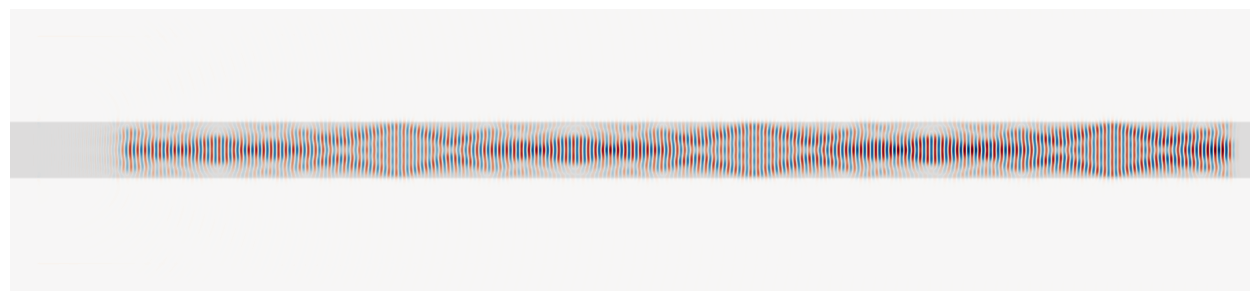

In [ ]:
# Source
sources = [mp.Source(mp.GaussianSource(wavelength=wl, fwidth=df),
                     component=mp.Ey,
                     center=mp.Vector3(-0.5 * sx + dpml),
                     size=mp.Vector3(0, w, 0))]

# Normalization run simulation
norm_sim = mp.Simulation(cell_size=cell,
                         boundary_layers=pml_layers,
                         geometry=[mp.Block(size=mp.Vector3(mp.inf, w, mp.inf), material=SiO2_material)],  # No holes for normalization
                         sources=sources,
                         resolution=resolution)



# Flux monitors
refl_fr = mp.FluxRegion(center=mp.Vector3(-0.5 * sx + dpml + 0.5), size=mp.Vector3(0, 2*w, 0))
tran_fr = mp.FluxRegion(center=mp.Vector3(0.5 * sx - dpml - 0.5), size=mp.Vector3(0, 2*w, 0))


# Add flux monitors
norm_refl = norm_sim.add_flux(fcen, df, nfreq, refl_fr)
norm_tran = norm_sim.add_flux(fcen, df, nfreq, tran_fr)

plt.figure(dpi=150)
norm_sim.plot2D()
plt.show()

# Run normalization simulation
norm_sim.run(until_after_sources=mp.stop_when_fields_decayed(50, mp.Ez, mp.Vector3(0.5 * sx - dpml - 0.5), 1e-3))

eps_data = norm_sim.get_array(center=mp.Vector3(), size=cell, component=mp.Dielectric)
ez_data = norm_sim.get_array(center=mp.Vector3(), size=cell, component=mp.Ey)
plt.figure(figsize=(16,9) )
plt.imshow(eps_data.transpose(), interpolation='spline36', cmap='binary')
plt.imshow(ez_data.transpose(), interpolation='spline36', cmap='RdBu', alpha=0.9)
plt.axis('off')
plt.show()

# Save flux for normalization
norm_refl_data = norm_sim.get_flux_data(norm_refl)
norm_tran_data = norm_sim.get_flux_data(norm_tran)

# Calculate the incident power for normalization
norm_refl_flux = mp.get_fluxes(norm_refl)
norm_tran_flux = mp.get_fluxes(norm_tran)
norm_incident_flux = np.array(norm_refl_flux) + np.array(norm_tran_flux)

# Reset simulation for main run with holes
norm_sim.reset_meep()

     block, center = (0,0,0)


          size (1e+20,2,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
     cylinder, center = (-18.5,0,0)
          radius 0.5, height 1e+20, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (1,1,1)
     cylinder, center = (-16.5,0,0)
          radius 0.5, height 1e+20, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (1,1,1)
     cylinder, center = (-13.5,0,0)
          radius 0.5, height 1e+20, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (1,1,1)
     cylinder, center = (-11.5,0,0)
          radius 0.5, height 1e+20, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (1,1,1)
     cylinder, center = (-8.5,0,0)
          radius 0.5, height 1e+20, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (1,1,1)
     cylinder, center = (-6.5,0,0)
          radius 0.5, height 1e+20, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (1

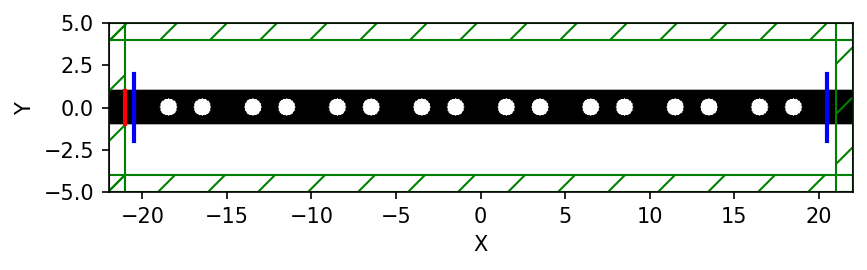

-----------
Initializing structure...
time for choose_chunkdivision = 0.000814915 s
Working in 2D dimensions.
Computational cell is 44 x 10 x 0 with resolution 20
     block, center = (0,0,0)
          size (1e+20,2,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
     cylinder, center = (-18.5,0,0)
          radius 0.5, height 1e+20, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (1,1,1)
     cylinder, center = (-16.5,0,0)
          radius 0.5, height 1e+20, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (1,1,1)
     cylinder, center = (-13.5,0,0)
          radius 0.5, height 1e+20, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (1,1,1)
     cylinder, center = (-11.5,0,0)
          radius 0.5, height 1e+20, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (1,1,1)
     cylinder, center = (-8.5,0,0)
          radius 0.5, height 1e+20, axis (0, 0, 1)
  

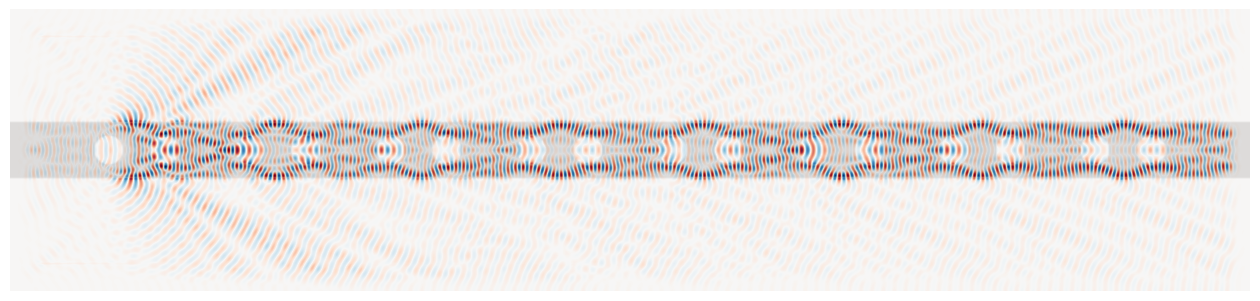

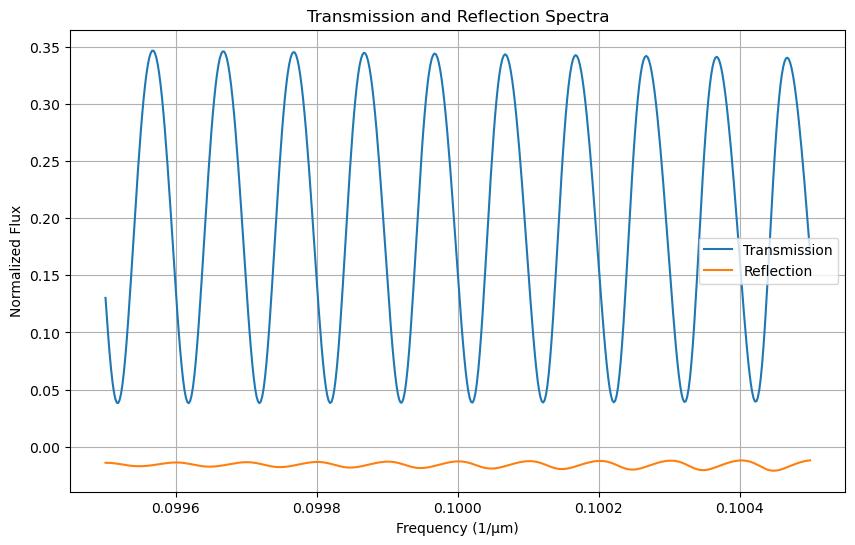

In [ ]:
# Main simulation with holes
geometry_holes = [mp.Block(size=mp.Vector3(mp.inf, w, mp.inf), material=SiO2_material)]

hole_positions = generate_waveguide(N, t_1, t_2, r)
for x_position in hole_positions:
    geometry_holes.append(mp.Cylinder(r, height=mp.inf, center=mp.Vector3(x_position, 0, 0), material=mp.air))

sim = mp.Simulation(cell_size=cell,
                    boundary_layers=pml_layers,
                    geometry=geometry_holes,  # Geometry with holes
                    sources=sources,
                    resolution=resolution)



# Add flux monitors
refl = sim.add_flux(fcen, df, nfreq, refl_fr)
tran = sim.add_flux(fcen, df, nfreq, tran_fr)

plt.figure(dpi=150)
sim.plot2D()
plt.show()

# Load the saved flux data for normalization
sim.load_minus_flux_data(refl, norm_refl_data)

# Run simulation with holes
sim.run(until_after_sources=mp.stop_when_fields_decayed(50, mp.Ez, mp.Vector3(0.5 * sx - dpml - 0.5), 1e-3))

eps_data = sim.get_array(center=mp.Vector3(), size=cell, component=mp.Dielectric)
ez_data = sim.get_array(center=mp.Vector3(), size=cell, component=mp.Ey)
plt.figure(figsize=(16,9) )
plt.imshow(eps_data.transpose(), interpolation='spline36', cmap='binary')
plt.imshow(ez_data.transpose(), interpolation='spline36', cmap='RdBu', alpha=0.9)
plt.axis('off')
plt.show()

# Get the reflected and transmitted flux
reflected_flux = mp.get_fluxes(refl)
transmitted_flux = mp.get_fluxes(tran)

# Normalize the transmission and reflection
transmission = np.array(transmitted_flux) / norm_incident_flux
reflection = np.array(reflected_flux) / norm_incident_flux
freqs = np.linspace(fcen - df/2, fcen + df/2, nfreq)

# Plot the transmission and reflection
plt.figure(figsize=(10, 6))
plt.plot(freqs, transmission, label="Transmission")
plt.plot(freqs, reflection, label="Reflection")
plt.xlabel("Frequency (1/μm)")
plt.ylabel("Normalized Flux")
plt.legend()
plt.title("Transmission and Reflection Spectra")
plt.grid(True)
plt.show()